# **PART II: SPEECH RECOGNITION WITH CONNECTIONIST TEMPORAL CLASSIFICATION**



# Introduction

**Import useful libraries**

In [1]:
pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149873 sha256=798536fb448705871c60eca52f5614d81a6a82682e5fccd1c2066ee5dec04595
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

from glob import glob
from jiwer import wer, cer
from tensorflow import keras
from tensorflow.keras import layers

**Define constant parameters**

In [3]:
# Signal processing parameters
fft_size = 512
frame_length = 512
frame_step = 256
mel_bins = 128

# Training parameters
batch_size = 64
units = 512
learning_rate = 1e-3
epochs = 100
steps = 128

# Preparing Att-HACK: A dataset of expressive speech


**Download the dataset**

In [5]:
from scipy.io import wavfile
import pandas as pd
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/')
save_path = '/content/'
wavs_path = save_path + 'Dataset'
DATA = pd.read_csv(save_path + 'DATA_alt.csv')
wavs = os.listdir(wavs_path)

data = [] # {"audio": [], "text": []}

for i in tqdm(range(len(DATA))):
    wav = DATA.iloc[i]['wav']
    txt = DATA.iloc[i]['txt']
    if os.path.exists(wavs_path+'/'+wav):
        data.append({'audio': wavs_path + '/' + wav, 'text': txt}) 

Mounted at /content/drive


100%|██████████| 1000/1000 [00:00<00:00, 1372.04it/s]


**Preprocess the dataset**

In [6]:
# Special characters to be replaced
special_char = {'â':'a', 
                'ê':'e',
                'ô':'o',
                'û':'u',
                'à':'a',
                'è':'e',
                'é':'e',
                '’':' ',
                "'":' ',
                "-":' '}
for sample in data:
    sample['text'] =  ''.join([ char if char not in special_char else special_char[char]
                       for char in sample['text'] ])

# Prepare the vocabulary to be used
characters = []
for sample in data:
    for char in sample['text']:
        if char not in characters:
            characters.append(char)
            
char_to_num = layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(char_to_num.get_vocabulary())

['', 'o', 'u', 'i', 'n', 'c', 'e', 'r', 't', 's', 'b', ' ', 'a', 'l', 'j', 'p', 'v', 'd', 'm', 'f', 'g', 'y', 'z', 'h', 'w', 'k', 'x', 'q']


**Split the dataset into training and test sets**

In [7]:
data_train, data_test = [], []
test_sentences = [ "tu as marche", "je suis parti sans trainer", "il est tard a londres", 
                   "veuillez m ecouter", "tu es parti pour l espagne", "nous avons chante",
                   "tu as fait ce que je voulais", "bonjour marie",  "il fait beau ce soir a paris",
                   "oui", "certes", "vous avez dit ce qu il fallait",  "salut",
                   "vous avez dormi toute la nuit",  "c est vrai allons prendre un cafe"]
for sample in data:
    if sample["text"] in test_sentences:
        data_test.append(sample)
    else:
        data_train.append(sample)

In [8]:
# Define the function to process both audios and sequences
def encode_single_sample(wav_file, labels):
    #################################################
    ## Process the audio
    #################################################
    # 1. Read raw wav data
    print(wav_file)
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file 
    audio, sample_rate = tf.audio.decode_wav(file)
    audio = tf.cast(tf.squeeze(audio, axis=-1), tf.float32)
    # 3. Compute magnitude spectrogram 
    spectrograms = tf.signal.stft(audio,
                                  frame_length=frame_length,
                                  frame_step=frame_step,
                                  fft_length=fft_size)
    spectrograms = tf.abs(spectrograms)
    # 4. Apply the mel filterbank
    mel_filters = tf.signal.linear_to_mel_weight_matrix(mel_bins,
                                                        1+fft_size//2,
                                                        sample_rate,
                                                        0.,
                                                        8000.)
    mel_spectrograms = tf.matmul(spectrograms, mel_filters)
    # . Normalisation
    means = tf.math.reduce_mean(mel_spectrograms, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrograms, 1, keepdims=True)
    mel_spectrograms = tf.divide(tf.subtract(mel_spectrograms, 
                                             means),
                                 stddevs+1e-10)

    #################################################
    ## Process the sequence
    #################################################
    # 9. Convert labels to lower case
    labels = tf.strings.lower(labels)
    # 10. Split the labels
    labels = tf.strings.unicode_split(labels, input_encoding="UTF-8")
    # 11. Map the characters in labels to numbers
    labels = 1+char_to_num(labels)
    # 12. Return both spectral and text inputs
    return mel_spectrograms, labels

**Preprocess the dataset**

In [9]:
# Create tf.data.Dataset objects that yield the transformed elements

# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([sample["audio"] for sample in data_train], 
     [sample["text"]  for sample in data_train])
)

train_dataset = (
    train_dataset.map(encode_single_sample,
                      num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=len(data_train))
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .repeat()
)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    ([sample["audio"] for sample in data_test], 
     [sample["text"]  for sample in data_test])
)

test_dataset = (
    test_dataset.map(encode_single_sample,
                    num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


**Visualize a data example**

In [10]:
from IPython.display import Audio 
from IPython.core.display import display
show_example = True

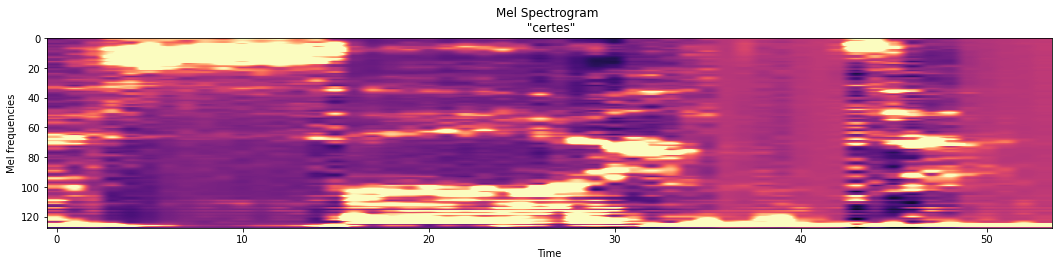

In [11]:
if show_example:
    fig = plt.figure(figsize=(18, 3.5))
    i_sample = random.sample(list(range(batch_size)),1)[0]
    for batch in test_dataset.take(1):
        #
        batch[0].shape
        spectrogram = batch[0][i_sample].numpy()
        spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
        label = batch[1][i_sample]
        label = tf.strings.reduce_join(num_to_char(label-1)).numpy().decode("utf-8")
        
        # Spectral representation
        ax = plt.subplot(1, 1, 1)
        plt.magma()
        ax.imshow(np.flip(spectrogram,axis=0), vmax=1, aspect='auto')
        ax.set_title("Mel Spectrogram \n \"{0}\"".format(label))
        ax.set_xlabel("Time")
        ax.set_ylabel("Mel frequencies")

    plt.show()

# Connectionist Temporal Classification

Connectionist Temporal Classification (CTC) is now the objective function that we aim to minimize. 
It features key main advantages:

*   Design for generic sequence-to-sequence predictions
*   Easily integrable into "end-to-end" model

The loss is defined as follows:

In [12]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length*tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length*tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# Neural Acoustic Model

## Bahdanau Attention

Attention mechanisms have shown to be central point in the speech recognition domain.

In [13]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.dense = layers.Dense(self.units)

    def get_config(self):
        return { "units": self.units }
    
    def call(self, key, query, value):
        # Attention learnable dense layer
        key = self.dense(key)

        # Attention scores
        attention_scores = tf.matmul(query, key, transpose_b=True)

        # Attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Attention context
        attention_context = tf.matmul(attention_weights, value)
        return attention_context, attention_weights 

## Model Architecture

When first introduced, for tackling the speech recognition problem, CTC was used to train Recurrent Neural Networks (RNN). The main advantage of RNN is their capability to process the entire input sequence at each training step contrary to convolutional networks (CNN).

We thus propose to define a RNN-based model and train it with respect to the CTC objective:

In [14]:
def build_model(input_dim, output_dim, deep_depth=4, learning_rate=1e-4, units=256, use_attention=False):
    # Retrieve the model input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    
    # Deep neural processing of input spectrograms...
    x = input_spectrogram
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    
    if use_attention:
        att_ctx, att_wgt = BahdanauAttention(2*units)(x, x, x)
        x = layers.Concatenate(axis=-1)([att_ctx, x])
    
    # Posteriogram, i.e., character and blank emission probability for each timestep
    logits = layers.Dense(units=output_dim+1)(x)
    output = layers.Activation("softmax")(logits)

    # Create the model architecture
    model_name = "model_attention" if use_attention else "model_base"
    model = keras.Model(input_spectrogram, output, name=model_name)
    
    # Set optimization
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model and return
    model.compile(optimizer=optimizer, loss=CTCLoss)
    return model

In [15]:
vocabulary_size=len(char_to_num.get_vocabulary())+1
model = build_model(input_dim=mel_bins,
                    output_dim=vocabulary_size,
                    units=units,
                    learning_rate=learning_rate,
                    use_attention=True)
model.summary(line_length=100)

Model: "model_attention"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 input (InputLayer)              [(None, None, 128)]   0           []                               
                                                                                                    
 bidirectional (Bidirectional)   (None, None, 1024)    2625536     ['input[0][0]']                  
                                                                                                    
 dropout (Dropout)               (None, None, 1024)    0           ['bidirectional[0][0]']          
                                                                                                    
 bidirectional_1 (Bidirectional)  (None, None, 1024)   6295552     ['dropout[0][0]']                
                                                                  

## Training / Loading trained weights

CTC generates, from audio only, posteriograms (per-time probability for each character to appear) that can be used to estimate the spoken sequence.

This, however, requires a utiliy function to decode the output of the network thanks to a search decoding:


In [16]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Sequence is decoded with beam search (alternatetively, greedy search)
    results = keras.backend.ctc_decode(pred, 
                                       input_length=input_len, 
                                       greedy=False, 
                                       beam_width=10, 
                                       top_paths=1)[0][0]

    # Iterate over the results and get the text back
    output_text = []
    for result in results:
        result -= 1 # padding token 
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

Setting up the above-mentioned model, callback, and train/test datasets, all we are left with is launching the training procedure or its resulted trained weights.

In [18]:
# Check if the model has already been trained and saved
weights_exist = os.path.exists(save_path+'ctc_weights.h5')
# Load pre-trained weights
model = tf.keras.models.load_model(save_path+'ctc_weights.h5',
                                   custom_objects={
                                       'BahdanauAttention': BahdanauAttention,
                                       'CTCLoss': CTCLoss
                                       })

## Inference

**Apply the model on all files from the test dataset**

In [19]:
predictions = []
targets = []
for batch in test_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = label-1
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)

**Plot a few predicted sequences**

In [20]:
print("-" * 100)
for i in np.random.randint(0, len(predictions)//2, 10):
    print(f"Target    : {targets[2*i]}")
    print(f"Prediction: {predictions[2*i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Target    : c est vrai allons prendre un cafe
Prediction: c est vrai alons prendre un cafe
----------------------------------------------------------------------------------------------------
Target    : il fait beau ce soir a paris
Prediction: il fait beau ce soir a paris
----------------------------------------------------------------------------------------------------
Target    : vous avez dit ce qu il fallait
Prediction: vous avez dit ce qu il falait
----------------------------------------------------------------------------------------------------
Target    : veuillez m ecouter
Prediction: veuilez m ecouter
----------------------------------------------------------------------------------------------------
Target    : il fait beau ce soir a paris
Prediction: il fait beau ce soir a paris
----------------------------------------------------------------------------------------------

**Evaluate the performances (WER and CER)**

In [21]:
wer_score = 100*wer(targets, predictions)
cer_score = 100*cer(targets, predictions)
print("-" * 100)
print(f"Char Error Rate (CER): {cer_score:.1f}%")
print(f"Word Error Rate (WER): {wer_score:.1f}%")
print("-" * 100)

----------------------------------------------------------------------------------------------------
Char Error Rate (CER): 3.3%
Word Error Rate (WER): 10.2%
----------------------------------------------------------------------------------------------------


**Observe the attention mechanism**

In [22]:
att_model = keras.Model(model.input, model.get_layer(index=7).output[-1] )
attentions = []
for batch in test_dataset.take(1):
    X, y = batch
    batch_attentions = att_model.predict(X)
    attentions.extend(batch_attentions)

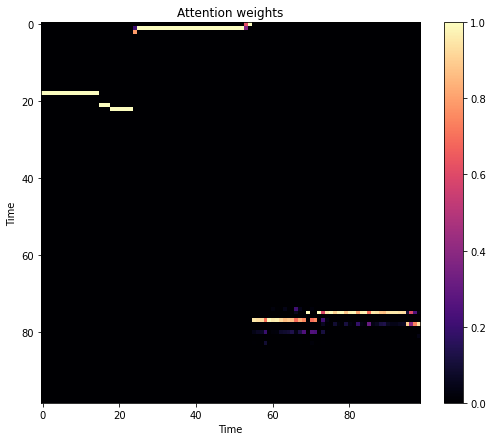

In [23]:
fig = plt.figure(figsize=(8.5, 7))
i_sample = random.sample(list(range(batch_size)),1)[0]

plt.magma()
plt.imshow(attentions[i_sample].T, vmax=1, aspect='auto')
plt.colorbar()
plt.title("Attention weights")
plt.xlabel("Time")
plt.ylabel("Time")
plt.show()